In [1]:
# Fundamentals
import os
import sys
import numpy as np
import pandas as pd
np.random.seed(55)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Machine Learning Algorithms
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

In [2]:
print('python', sys.version.split(' ')[0])
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('sklearn', sklearn.__version__)

python 3.7.7
numpy 1.18.5
pandas 1.0.5
sklearn 0.23.1


In [3]:
os.getcwd()

'E:\\bs\\python'

In [4]:
print(sys.getdefaultencoding())

utf-8


In [6]:
sample_submission = pd.read_csv("./data/sample_submission.csv")
train = pd.read_csv("./data/train.csv", index_col='id')
test = pd.read_csv("./data/test.csv", index_col='id')

In [8]:
indicator_dict = {
    'temperature'   : ["X00","X07","X28","X31","X32"], #기온
    'localpressure' : ["X01","X06","X22","X27","X29"], #현지기압
    'windspeed'     : ["X02","X03","X18","X24","X26"], #풍속
    'precipitation' : ["X04","X10","X21","X36","X39"], #일일 누적강수량
    'atmpressure'   : ["X05","X08","X09","X23","X33"], #해면기압
    'insolation'    : ["X11","X34","X14","X16","X19"], #일일 누적일사량
    'humidity'      : ["X12","X20","X30","X37","X38"], #습도
    'winddirection' : ["X13","X15","X17","X25","X35"], #풍향
}

In [9]:
idx1 = train[train['Y18'].isnull()].index
idx2 = train[~train['Y18'].isnull()].index

train1_X = train[train.columns[:40]].loc[idx1].copy()
train1_Ys = train[train.columns[40:-1]].loc[idx1].copy()

train2_X = train[train.columns[:40]].loc[idx2].copy()
train2_Y18 = train[train.columns[-1]].loc[idx2].copy()

test_X = test.copy()

combined_X = pd.concat([train1_X, train2_X, test_X], axis=0)
X_list = [train1_X, train2_X, test_X]

In [26]:
combined_X.columns

Index(['X00', 'X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09',
       'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29',
       'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39'],
      dtype='object')

In [14]:
print(combined_X.isnull().sum().sum())
print(train1_Ys.isnull().sum().sum())
print(train2_Y18.isnull().sum())

0
0
0


In [19]:
indicator_dict.items()

dict_items([('temperature', ['X00', 'X07', 'X28', 'X31', 'X32']), ('localpressure', ['X01', 'X06', 'X22', 'X27', 'X29']), ('windspeed', ['X02', 'X03', 'X18', 'X24', 'X26']), ('precipitation', ['X04', 'X10', 'X21', 'X36', 'X39']), ('atmpressure', ['X05', 'X08', 'X09', 'X23', 'X33']), ('insolation', ['X11', 'X34', 'X14', 'X16', 'X19']), ('humidity', ['X12', 'X20', 'X30', 'X37', 'X38']), ('winddirection', ['X13', 'X15', 'X17', 'X25', 'X35'])])

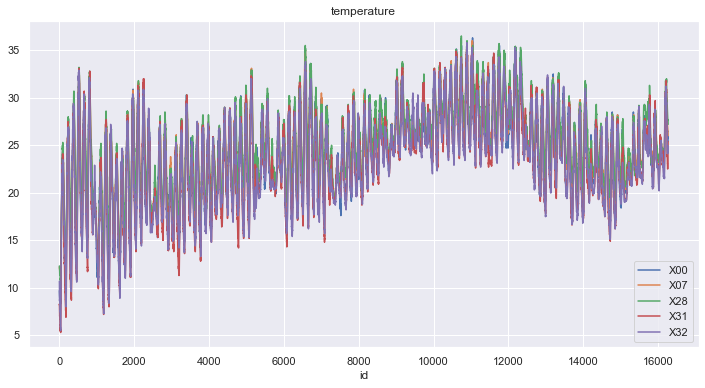

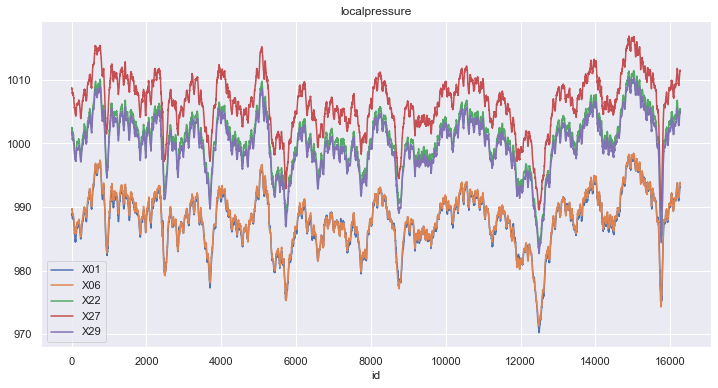

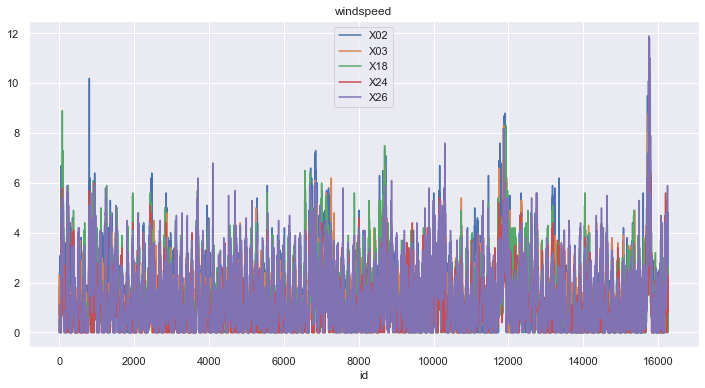

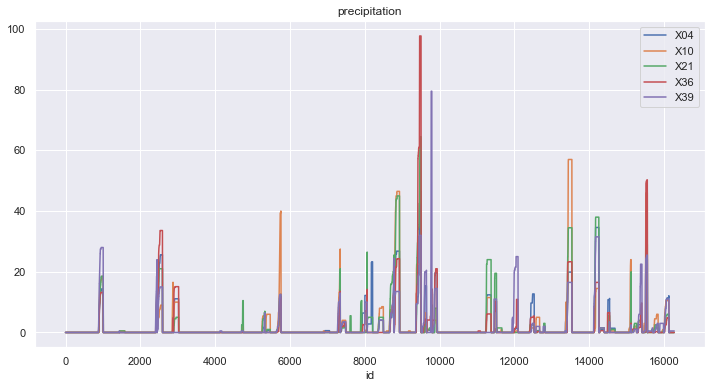

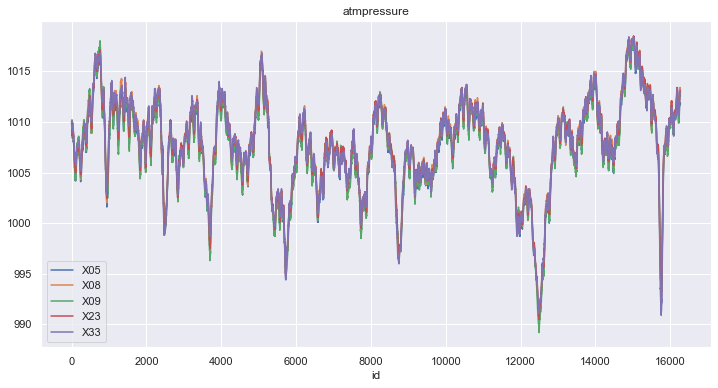

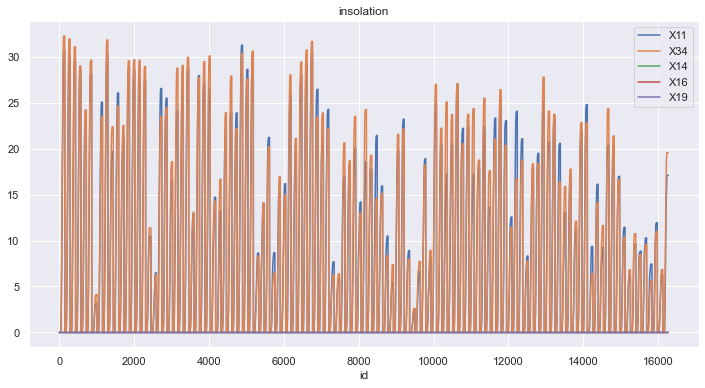

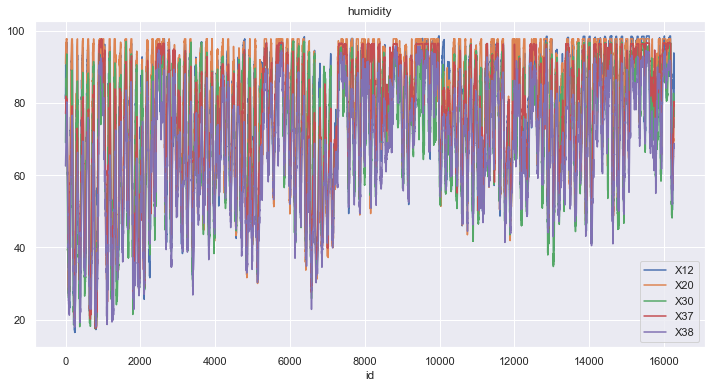

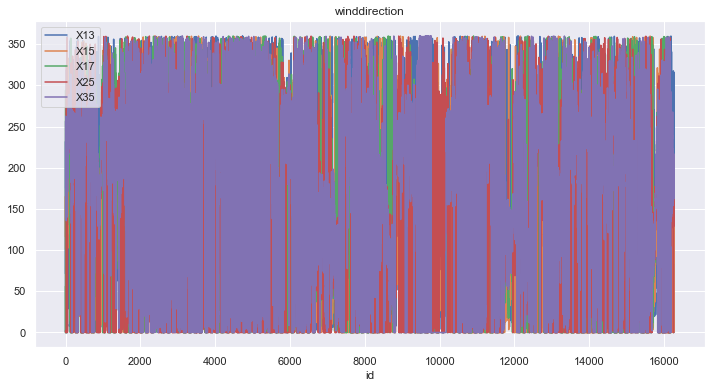

In [15]:
for k, v in indicator_dict.items():
    combined_X.reset_index().plot(x='id', y=v, figsize=(12, 6))
    plt.gca().set_title(k)

In [27]:
# Insolation 에서 X14, X16, X19 는 관측지가 없음. => Drop!
for X in X_list + [combined_X]:
    X.drop(['X14', 'X16', 'X19'], axis=1, inplace=True)


In [30]:
indicator_dict['insolation'] = ["X11","X34"]

In [31]:
for X in X_list + [combined_X]:
    X['date'] = X.index // 144
    X['time'] = X.index % 144

In [47]:
for X in X_list:
    dates = X['date'].unique()
    for d in dates:
        day_idx = X.loc[X['date'] == d].index
        for f in indicator_dict['insolation']:
            X.loc[day_idx, f] = X.loc[day_idx, f] - X.loc[day_idx, f].shift(periods=6).fillna(0)

In [52]:
for X in X_list:
    dates = X['date'].unique()
    for f in indicator_dict['precipitation']:
        for d in dates[::-1]:
            day_idx = combined_X.loc[combined_X['date'] == d].index
            yes_day_idx = combined_X.loc[(combined_X['date'] == d-1)].index
            day_precip = combined_X.loc[(yes_day_idx | day_idx), f]
            
            # 편의를 위해 Train1, Train2, Test set 각각의 첫날(d=0)의 하루 전 누적 강수량은 0으로 고정함.
            yesterday_cum_precip = day_precip.loc[yes_day_idx].max() if d != 0 else 0 
            day_precip.loc[day_idx] += yesterday_cum_precip
            day_precip_shift = day_precip.shift(periods=36).fillna(0)
            
            X.loc[day_idx, f] = day_precip.loc[day_idx] - day_precip_shift.loc[day_idx]

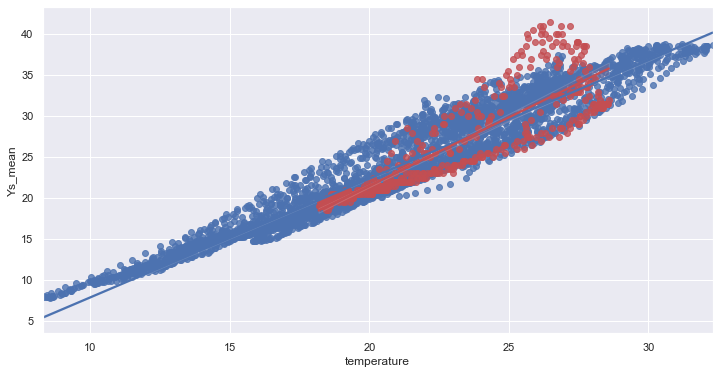

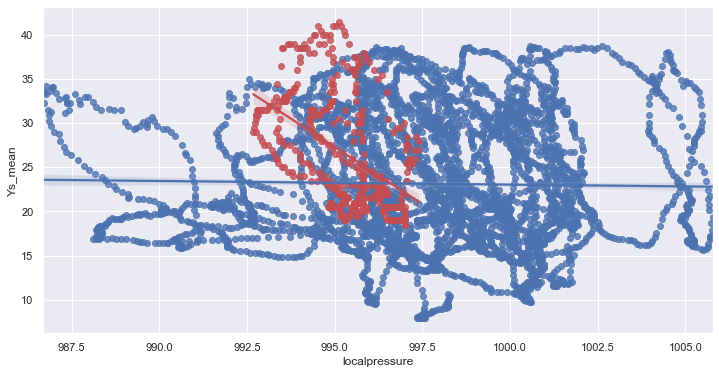

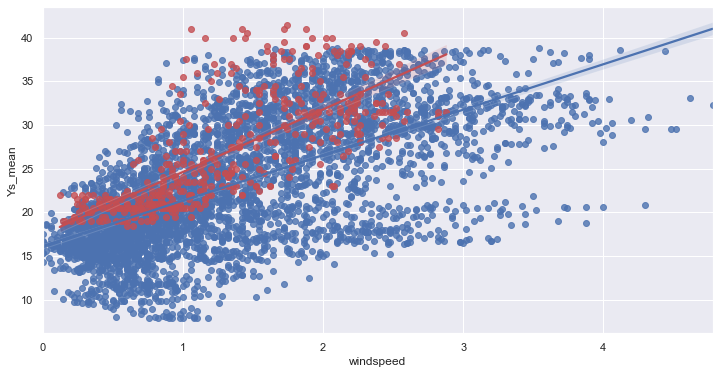

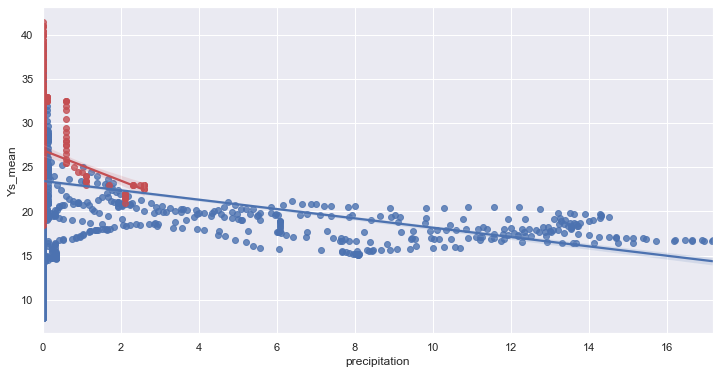

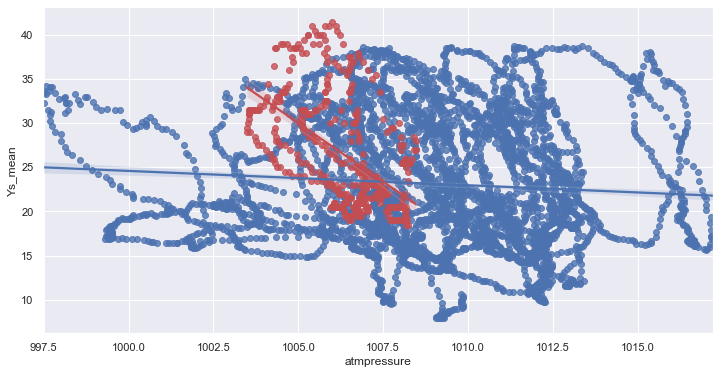

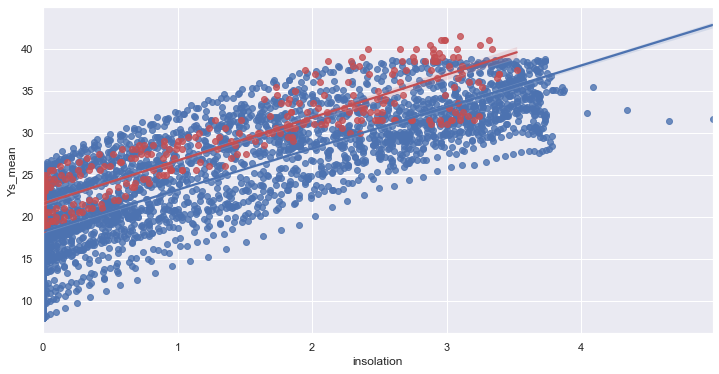

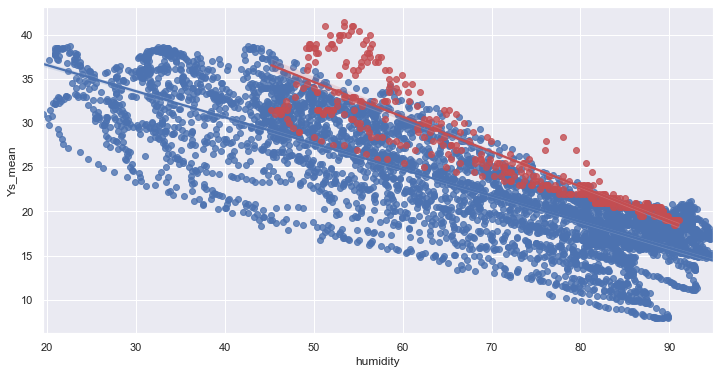

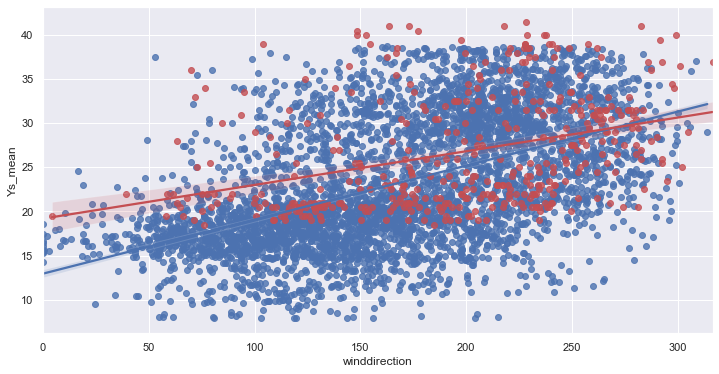

In [54]:
train1_Ys_mean = train1_Ys.mean(axis=1)
for k, v  in indicator_dict.items():
    train1_feature_mean = train1_X[v].mean(axis=1)
    train2_feature_mean = train2_X[v].mean(axis=1)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.regplot(train1_feature_mean, train1_Ys_mean, ax=ax)
    sns.regplot(train2_feature_mean, train2_Y18, ax=ax, color='r')
    ax.set_xlabel(k)
    ax.set_ylabel('Ys_mean')

In [55]:
train2_feature_mean

id
4320    217.26
4321    238.38
4322    188.98
4323    122.64
4324    119.72
         ...  
4747    220.42
4748    180.48
4749    187.44
4750    175.78
4751     82.48
Length: 432, dtype: float64

In [56]:
for df in X_list:
    df.drop(indicator_dict['localpressure'], axis=1, inplace=True)
    df.drop(indicator_dict['atmpressure'], axis=1, inplace=True)
    df.drop(indicator_dict['windspeed'], axis=1, inplace=True)
    df.drop(indicator_dict['winddirection'], axis=1, inplace=True)
    df.drop(indicator_dict['precipitation'], axis=1, inplace=True)
indicator_dict = dict((k,indicator_dict[k]) for k in ['temperature', 'humidity', 'insolation'] if k in indicator_dict)

In [57]:
indicator_dict

{'temperature': ['X00', 'X07', 'X28', 'X31', 'X32'],
 'humidity': ['X12', 'X20', 'X30', 'X37', 'X38'],
 'insolation': ['X11', 'X34']}

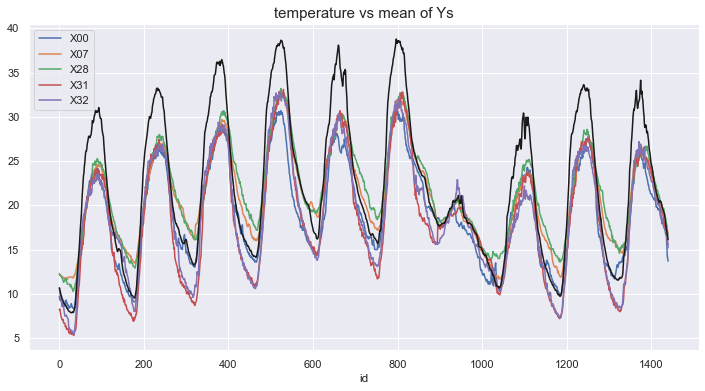

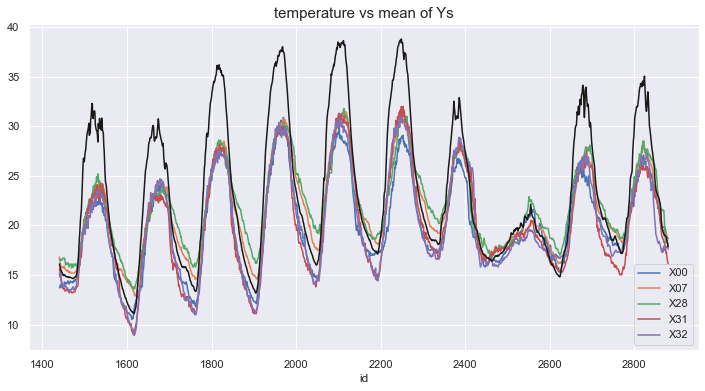

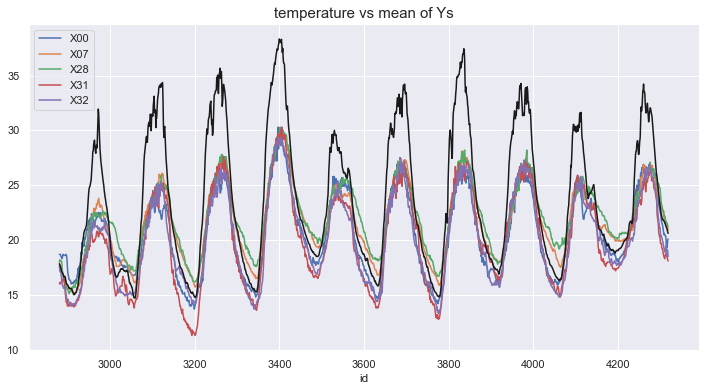

In [59]:
# 30일을 10일 단위로 나누어 visualization.
# vs temperature
for idx in range(0, 30, 10):
    idx1, idx2 = 144*idx, 144*(idx+10)

    fig, ax = plt.subplots(figsize=(12, 6))
    train1_X.loc[idx1:idx2, indicator_dict['temperature']].plot(ax=ax)
    train1_Ys_mean.loc[idx1:idx2].plot(ax=ax, color='k')
    ax.set_title('temperature vs mean of Ys', size=15)

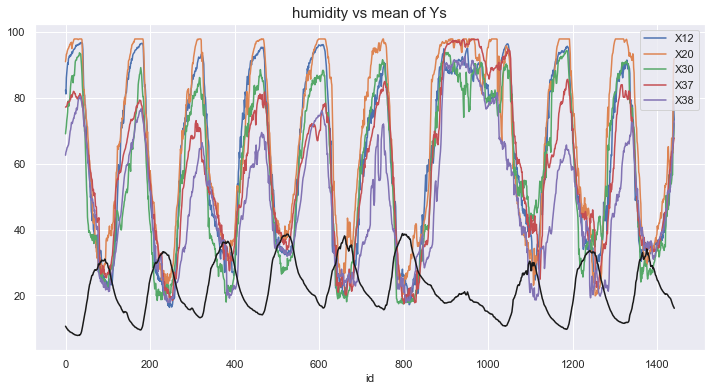

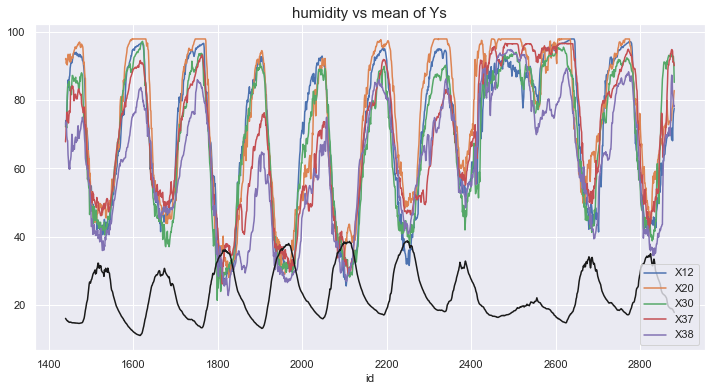

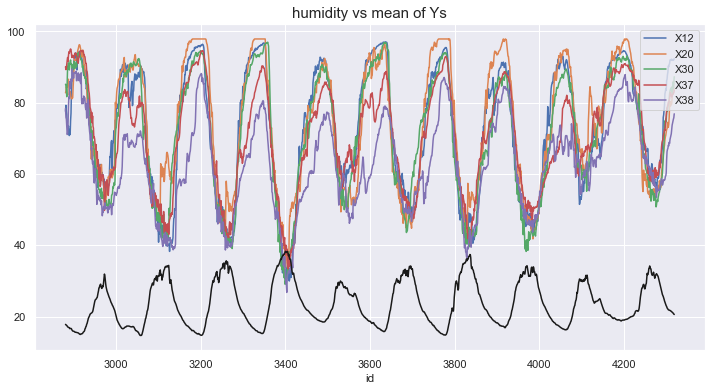

In [60]:
for idx in range(0, 30, 10):
    idx1, idx2 = 144*idx, 144*(idx+10)

    fig, ax = plt.subplots(figsize=(12, 6))
    train1_X.loc[idx1:idx2, indicator_dict['humidity']].plot(ax=ax)
    train1_Ys_mean.loc[idx1:idx2].plot(ax=ax, color='k')
    ax.set_title('humidity vs mean of Ys', size=15)

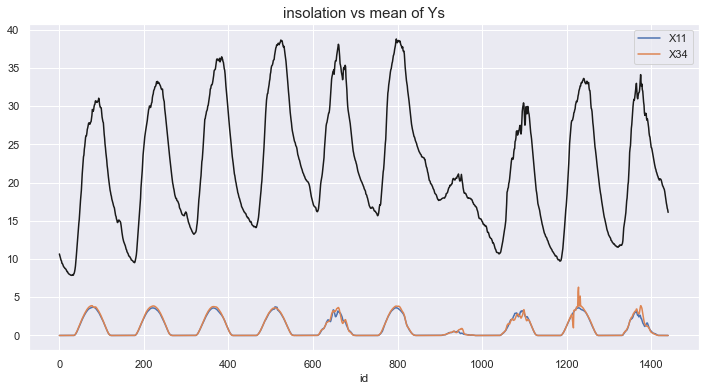

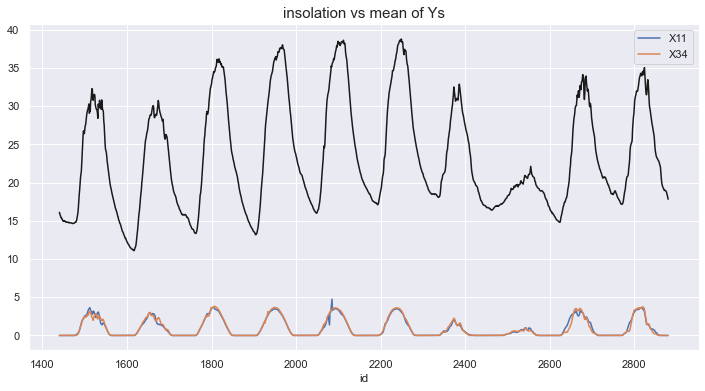

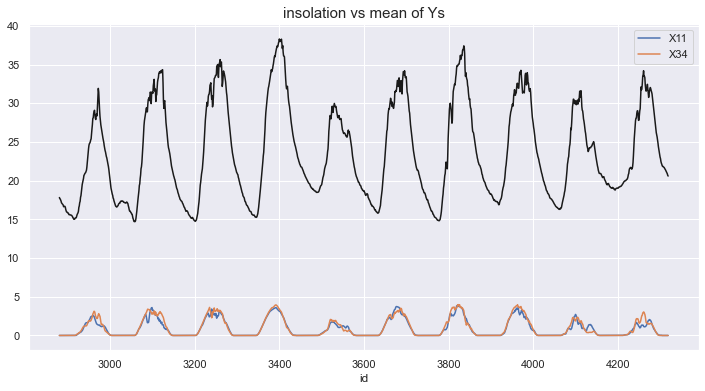

In [61]:
# vs insolation
for idx in range(0, 30, 10):
    idx1, idx2 = 144*idx, 144*(idx+10)

    fig, ax = plt.subplots(figsize=(12, 6))
    train1_X.loc[idx1:idx2, indicator_dict['insolation']].plot(ax=ax)
    train1_Ys_mean.loc[idx1:idx2].plot(ax=ax, color='k')
    ax.set_title('insolation vs mean of Ys', size=15)

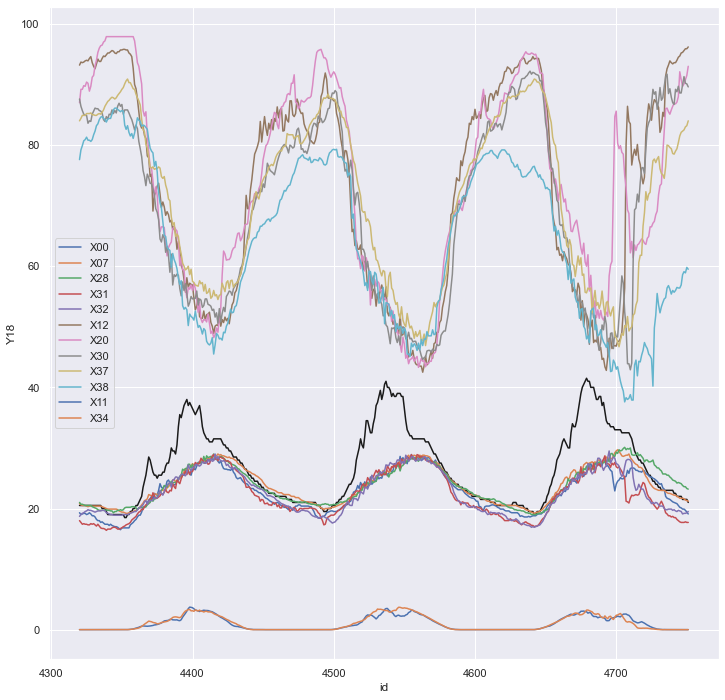

In [62]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(x=train2_X.index, y=train2_Y18, ax=ax, c='k')
train2_X[indicator_dict['temperature']].plot(ax=ax)
train2_X[indicator_dict['humidity']].plot(ax=ax)
train2_X[indicator_dict['insolation']].plot(ax=ax)

In [63]:
for X in X_list:
    insol = X['X34']
    insol.index = X.index
    neg_insol = pd.Series(np.zeros_like(insol.values), index=X.index)

    time1_index = X.loc[X['time'] == 80].index  # 그림자가 지기 시작하는 시간
    time2_index = X.loc[X['time'] == 89].index  # 그림자가 완전히 진 시간
    end_index = X.loc[X['time'] == 143].index

    for t1, t2, end in zip(time1_index, time2_index, end_index):
        neg_insol.loc[t1:t2-1] = insol.loc[t1:t2-1] * (np.logspace(-1, 0, (t2-t1))-0.1)
        neg_insol.loc[t2:end] = insol.loc[t2:end]
    
    # 해가 질수록 (humidity가 상승할수록) neg insol의 영향력이 줄어들어야 한다고 판단하여 neg_insol에 mean of humidity를 곱해줌.
    humidity_mean = X[indicator_dict['humidity']].mean(1) / 100
    X['neg_insol'] = neg_insol * (1-humidity_mean)
    
indicator_dict['insolation'].append('neg_insol')

In [64]:
indicator_dict

{'temperature': ['X00', 'X07', 'X28', 'X31', 'X32'],
 'humidity': ['X12', 'X20', 'X30', 'X37', 'X38'],
 'insolation': ['X11', 'X34', 'neg_insol']}

In [65]:
# Remove out noisy features
for X in X_list:
    X.drop(['X00', 'X11'], axis=1, inplace=True) # X00, X11 seems to be inconsistent with Y18.
indicator_dict['temperature'].remove('X00')
indicator_dict['insolation'].remove('X11')

# Remove date and time
for X in X_list:
    X.drop(['date', 'time'], axis=1, inplace=True)

In [66]:
# Function for getting split index
def day_night_split(X, day_index, night_index):
    X['time'] = X.index % 144
    
    cond = (X['time']>=night_index)
    day_ids = X.loc[cond].index
    night_ids = X.loc[~cond].index
    
    X.drop('time', axis=1, inplace=True)
    return day_ids, night_ids


# Function for getting train2_Ys, test_Ys, and coefficients of mapping X -> Ys
def X_Ys_training(train1_X, train1_Ys, train2_X, test_X, day_index, night_index, multi=False):
    # multi_model에서 day, night index를 담는 grid. single model에서는 활용하지 않음.
    if multi:
        # day-night 경계에서 보다 seamless한 추정을 하도록 multiple index에 대해 training한 후 평균을 냄. 
        # multiple index는 day_index, night_index 기준으로 앞뒤로 30분, 60분 지점들의 combination을 meshgrid 형태로 저장함. (5*5=25 models)
        day_grid = np.meshgrid(np.arange(day_index-6, day_index+7, 3), np.arange(night_index-6, night_index+7, 3))[0].reshape(-1)
        night_grid = np.meshgrid(np.arange(day_index-6, day_index+7, 3), np.arange(night_index-6, night_index+7, 3))[1].reshape(-1)
        n_models = day_grid.shape[0]  # n_models=25
    else:
        day_grid, night_grid = [day_index], [night_index]
        n_models = 1
    
    # Ys->Y18 학습에 필요한 train2_Ys, test_Ys 결과 값을 저장할 DataFrame
    train2_Ys = pd.DataFrame(np.zeros((train2_X.shape[0], train1_Ys.shape[1])), index=train2_X.index, columns=train1_Ys.columns)
    test_Ys = pd.DataFrame(np.zeros((test_X.shape[0], train1_Ys.shape[1])), index=test_X.index, columns=train1_Ys.columns)
    
    # Y00부터 Y17까지의 X->Y mapping의 coefficients를 저장하는 리스트. 각 coefficients는 index가 time(0~144)이고 columns가 X(X00, X02, ... , neg_insol)인 DataFrame.
    X_Ys_coefs_list = []
    for i in range(len(train1_Ys.columns)):
        coefs_df = pd.DataFrame(np.zeros((144, train1_X.shape[1])), index=np.arange(144), columns=train1_X.columns)
        coefs_df['Ys_intercept'] = 0  # X->Ys에 대한 intercept column
        X_Ys_coefs_list.append(coefs_df)
    
    # Ys를 구하는 model은 효율을 위해 LassoCV가 아닌 Lasso를 적용.
    lasso = Lasso(alpha=0.05)
    
    # n_models개의 Day, night index의 조합에 대해 각각 model을 학습해 coefficients를 구함. (5*5=25 models)
    for day, night in zip(day_grid, night_grid):
        tr1_day_ids, tr1_night_ids = day_night_split(train1_X, day, night)
        day_train1_X, night_train1_X = train1_X.loc[tr1_day_ids], train1_X.loc[tr1_night_ids]
        
        tr2_day_ids, tr2_night_ids = day_night_split(train2_X, day, night)
        day_train2_X, night_train2_X = train2_X.loc[tr2_day_ids], train2_X.loc[tr2_night_ids]
                
        ts_day_ids, ts_night_ids = day_night_split(test_X, day, night)
        day_test_X, night_test_X = test_X.loc[ts_day_ids], test_X.loc[ts_night_ids]
        
        # 낮 시간대에서 X12(humidity), X20(humidity)가 noisy 하기 때문에 drop.
        for day_X in [day_train1_X, day_train2_X, day_test_X]:
            day_X.drop(['X12', 'X20'], axis=1, inplace=True)
            
        # 밤 시간대에서 X31(temperature), X38(humidity)가 noisy 하기 때문에 drop
        for night_X in [night_train1_X, night_train2_X, night_test_X]:
            night_X.drop(['X31', 'X38'], axis=1, inplace=True)
        
        # Y00부터 Y17까지 Loop
        for i, c_name in enumerate(train1_Ys.columns):
            # ----------- Day training -----------
            day_train1_Y = train1_Ys.loc[tr1_day_ids, c_name]
            lasso.fit(day_train1_X, day_train1_Y)
            
            # day_time에 대한 coefficients를 X_Ys_coefs_list에 저장. n개의 model에서의 coefficients들의 평균을 얻기 위해 n_models로 나누어줌.
            day_time = range(day+1, night+1)
            coefs = np.tile(lasso.coef_, (len(day_time), 1)) / n_models
            X_Ys_coefs_list[i].loc[day_time, day_train1_X.columns] += coefs
            X_Ys_coefs_list[i].loc[day_time, 'Ys_intercept'] += lasso.intercept_ / n_models
            
            # train2_Ys, test_Ys Predict. n개의 model에서의 prediction 값의 평균을 얻기 위해 n_models로 나누어줌.
            train2_Ys.loc[tr2_day_ids, c_name] += lasso.predict(day_train2_X) / n_models
            test_Ys.loc[ts_day_ids, c_name] += lasso.predict(day_test_X) / n_models
            
            # ----------- Night training -----------
            # Same as Day training
            night_train1_Y = train1_Ys.loc[tr1_night_ids, c_name]
            lasso.fit(night_train1_X, night_train1_Y)
            
            night_time = list(range(0, day+1)) + list(range(night+1, 144))
            coefs = np.tile(lasso.coef_, (len(night_time), 1)) / n_models
            X_Ys_coefs_list[i].loc[night_time, night_train1_X.columns] += coefs
            X_Ys_coefs_list[i].loc[night_time, 'Ys_intercept'] += lasso.intercept_ / n_models
            
            train2_Ys.loc[tr2_night_ids, c_name] += lasso.predict(night_train2_X) / n_models
            test_Ys.loc[ts_night_ids, c_name] += lasso.predict(night_test_X) / n_models
    
    return train2_Ys, test_Ys, X_Ys_coefs_list


# train2_Y18에 대해 correlation 값이 상위 n개인 Y들을 구함 -> Ys_high_correlated
def high_corr_Ys(train2_Ys, train2_Y18, n=None):
    if n==None:
        n = train2_Ys.shape[1]
        
    corrs = pd.DataFrame(index=train2_Ys.columns, columns=['corr'])
    for c in train2_Ys:
        corrs.loc[c, 'corr'] = np.corrcoef(train2_Ys[c], train2_Y18)[0,1]
    corrs = corrs.sort_values(by='corr', ascending=False)
    
    Ys_high_correlated = corrs[corrs.columns[:n]].index
 
    return Ys_high_correlated


# Function for getting coefficients of mapping Ys -> Y18
def Ys_Y18_training(train1_X, train2_Ys, train2_Y18, test_Ys, X_Ys_coefs_list, day_index, night_index):
    tr2_day_ids, tr2_night_ids = day_night_split(train2_Ys, day_index, night_index)
    day_train2_Ys, night_train2_Ys = train2_Ys.loc[tr2_day_ids], train2_Ys.loc[tr2_night_ids]
    day_train2_Y18, night_train2_Y18 = train2_Y18.loc[tr2_day_ids], train2_Y18.loc[tr2_night_ids]
    
    # X->Y18 mapping의 coefficients를 저장하는 DataFrame. index는 time(0~144)이고 columns는 X(X00, X02, ... , neg_insol)임.
    X_Y18_coefs = pd.DataFrame(np.zeros((144, train1_X.shape[1])), index=np.arange(144), columns=train1_X.columns)
    X_Y18_coefs['Ys_intercept'] = 0  # X->Ys 에서의 intercept에 대한 coefficient
    X_Y18_coefs['Y18_intercept'] = 0  # Ys->Y18 에서의 intercept에 대한 coefficient 
    
    # Day, Night index에 따라 optimal alpha 값이 달라지므로, LassoCV를 이용함.
    model = LassoCV(eps=0.01, n_alphas=40, cv=5, n_jobs=-1)
    
    # Day training
    day_Ys_high_correlated = high_corr_Ys(day_train2_Ys, day_train2_Y18, n=10)  # correlation이 높음 10개의 Y로 training을 진행.
    day_train2_Ys = day_train2_Ys[day_Ys_high_correlated]
    model.fit(day_train2_Ys, day_train2_Y18)
    
    # Ys->Y18에 더함.
    # 예를 들어, Ys->Y18의 coefficients가 {'Y00': 0, Y01': 1.2, 'Y02': 0.1} 이라고 하면 X_Y18_coefs는 아래와 같이 구할 수 있음.
    # X_Y18_coefs = (X_Ys_coefs_list[0] * 0) + (X_Ys_coefs_list[1] * 1.2) + (X_Ys_coefs_list[2] * 0.1) 
    # day와 night에 각각에 대해 X_Y18_coefs를 계산한다.
    Ys_Y18_coefs = pd.Series(model.coef_, index=day_train2_Ys.columns)
    Ys_Y18_coefs = Ys_Y18_coefs.loc[Ys_Y18_coefs!=0]
    day_time = np.arange(day_index+1, night_index+1)
    for Y in Ys_Y18_coefs.index:
        idx = np.where(train2_Ys.columns==Y)[0][0]
        X_Y18_coefs.loc[day_time, X_Y18_coefs.columns[:-1]] += X_Ys_coefs_list[idx].loc[day_time] * Ys_Y18_coefs.loc[Y]
        X_Y18_coefs.loc[day_time, 'Y18_intercept'] = model.intercept_
    
    # Night training (Same as Day training)
    night_Ys_high_correlated = high_corr_Ys(night_train2_Ys, night_train2_Y18, n=10)
    night_train2_Ys = night_train2_Ys[night_Ys_high_correlated]
    model.fit(night_train2_Ys, night_train2_Y18)
    
    Ys_Y18_coefs = pd.Series(model.coef_, index=night_train2_Ys.columns)
    Ys_Y18_coefs = Ys_Y18_coefs.loc[Ys_Y18_coefs!=0]
    night_time = list(range(0, day_index+1)) + list(range(night_index+1, 144))
    for Y in Ys_Y18_coefs.index:
        idx = np.where(train2_Ys.columns==Y)[0][0]
        X_Y18_coefs.loc[night_time, X_Y18_coefs.columns[:-1]] += X_Ys_coefs_list[idx].loc[night_time] * Ys_Y18_coefs.loc[Y]
        X_Y18_coefs.loc[night_time, 'Y18_intercept'] = model.intercept_
    
    return X_Y18_coefs


# Function for predicting Y18 with X_Y18_coefs. 
def predict_Y18(train1_X, target_X, X_Y18_coefs):
    scaler = StandardScaler().fit(train1_X)
    target_X = pd.DataFrame(scaler.transform(target_X), index=target_X.index, columns=target_X.columns)
  
    # intercept는 변수가 아니므로 1.0으로 고정함. (X_Y18_coefs에 저장된 값을 그대로 사용하기 위해) 
    target_X['Ys_intercept'] = 1.0
    target_X['Y18_intercept'] = 1.0
    
    target_Y18 = pd.Series(np.zeros((target_X.shape[0])), index=target_X.index)

    # time 0부터 143까지, target_X의 시간 t의 데이터와 X_Y18_coefs의 시간 t에 대한 coefficients를 inner product.
    for t in range(144):
        Y_pred = target_X.loc[(target_X.index%144)==t].dot(X_Y18_coefs.loc[t].values)
        target_Y18.loc[Y_pred.index] = Y_pred
    
    target_X.drop(['Ys_intercept', 'Y18_intercept'], axis=1, inplace=True)
    
    return target_Y18

In [68]:
# model for single day, night index 
def single_model(train1_X, train1_Ys, train2_X, train2_Y18, test_X, day_night_index, multi=False):
    day_index, night_index = day_night_index
    print('day_index : %s, night_index : %s' % (day_index, night_index))
    # ----------------------- Standard Scaler -----------------------
    scaler = StandardScaler().fit(train1_X)
    train1_X = pd.DataFrame(scaler.transform(train1_X), index=train1_X.index, columns=train1_X.columns)
    train2_X = pd.DataFrame(scaler.transform(train2_X), index=train2_X.index, columns=train2_X.columns)
    test_X = pd.DataFrame(scaler.transform(test_X), index=test_X.index, columns=test_X.columns)

    # ----------------------- Predict Y00-Y17 -----------------------
    train2_Ys, test_Ys, X_Ys_coefs_list = X_Ys_training(train1_X, train1_Ys, train2_X, test_X, day_index, night_index, multi)
    
    # ----------------------- Predict Y18 -----------------------
    X_Y18_coefs = Ys_Y18_training(train1_X, train2_Ys, train2_Y18, test_Ys, X_Ys_coefs_list, day_index, night_index)
    
    # multi인 경우엔 predict를 하지 않고 coefs만 return함.
    if multi:
        return X_Y18_coefs
    else:
        train2_Y18_pred = predict_Y18(train1_X, train2_X, X_Y18_coefs)
        test_Y18 = predict_Y18(train1_X, test_X, X_Y18_coefs)
        return train2_Y18_pred, test_Y18,  X_Y18_coefs

In [69]:
single_train2_Y18_pred, single_test_Y18, single_X_Y18_coefs =\
single_model(train1_X, train1_Ys, train2_X, train2_Y18, test_X, day_night_index=(33, 100), multi=False)

day_index : 33, night_index : 100


In [71]:
mean_squared_error(single_train2_Y18_pred, train2_Y18)

14.323913656180887

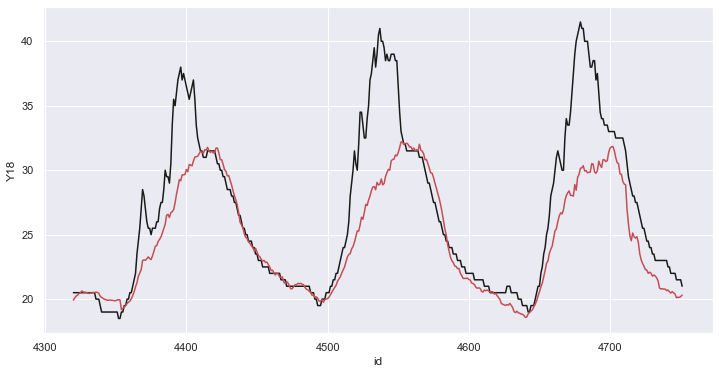

In [72]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=train2_Y18.index, y=train2_Y18, ax=ax, c='k')
sns.lineplot(x=train2_Y18.index, y=single_train2_Y18_pred, ax=ax, c='r')

In [ ]:
def multi_model(day_start, day_end, night_start, night_end, predict=True, **single_model_params):
    # day, night index의 grid. 총 ((day_end - day_start) / 2) * ((night_end - night_start) / 2) 개의 models.
    day_grid = np.meshgrid(np.arange(day_start, day_end, 2), np.arange(night_start, night_end, 2))[0].reshape(-1)
    night_grid = np.meshgrid(np.arange(day_start, day_end, 2), np.arange(night_start, night_end, 2))[1].reshape(-1)
    n_models = day_grid.shape[0]
    
    # Multiprocessing
    pool = ThreadPool(8)
    X_Y18_coefs_list = pool.map(lambda grid: single_model(day_night_index=grid, multi=True, **single_model_params), zip(day_grid, night_grid))
    
    # list에 저장된 multiprocessing의 결과(coefficients for each day, night combination)의 평균값을 구함.
    multi_X_Y18_coefs = pd.DataFrame(np.zeros((144, train1_X.shape[1])), index=np.arange(144), columns=train1_X.columns)
    multi_X_Y18_coefs['Ys_intercept'] = 0
    multi_X_Y18_coefs['Y18_intercept'] = 0
    for coefs in X_Y18_coefs_list:
        multi_X_Y18_coefs += coefs
    multi_X_Y18_coefs /= n_models
    
    # Predict Y18
    if predict:
        train2_Y18 = predict_Y18(train1_X, train2_X, multi_X_Y18_coefs)
        test_Y18 = predict_Y18(train1_X, test_X, multi_X_Y18_coefs)
        return train2_Y18, test_Y18, multi_X_Y18_coefs
    else:
        return multi_X_Y18_coefs

# %%time
# day_start, day_ends, night_start, night_end 값은 리더보드 점수가 가장 높은 것으로 선택함.
train2_Y18_pred, test_Y18, multi_X_Y18_coefs = multi_model(day_start=21, day_end=45, night_start=91, night_end=109, predict=True,
                                                           train1_X=train1_X, train1_Ys=train1_Ys, train2_X=train2_X, train2_Y18=train2_Y18, test_X=test_X)

# Training error
mean_squared_error(train2_Y18_pred, train2_Y18)

# Visualization : train2_Y18 prediction 
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=train2_Y18.index, y=train2_Y18, ax=ax, c='k')
sns.lineplot(x=train2_Y18.index, y=train2_Y18_pred, ax=ax, c='r')

day_index : 21, night_index : 91day_index : 29, night_index : 91day_index : 37, night_index : 91


day_index : 21, night_index : 93
day_index : 29, night_index : 93day_index : 37, night_index : 93

day_index : 21, night_index : 95
day_index : 29, night_index : 95


In [ ]:
# Visualization : test_Y18 prediction
for idx in range(33, 113, 20):
    idx1, idx2 = 144*idx, 144*(idx+20)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=np.arange(idx1, idx2), y=test_Y18.loc[idx1:idx2-1], ax=ax, c='r')